In [60]:
%matplotlib inline
from __future__ import division
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import Image

plt.rcParams['figure.figsize'] = (12,6)

from utils import draw_in_row

In [61]:
class NormalDistribution(object):
    def __init__(self, x=None, mu=None, sigma=None):
        if x is not None:
            self.fit(x)
        else:
            if mu is not None:
                self.mu = mu
            if sigma is not None:
                self.sigma = sigma
    
    def fit(self, x):
        self.mu = x.mean()
        self.sigma = x.std()
    
    def pdf(self,x):
        return norm.pdf(x, loc=self.mu, scale=self.sigma)
    
    def sample(self, n):
        return norm.rvs(loc=self.mu, scale=self.sigma, size=n)

# Binary classification example

Imagine a simple classification example between lemons and oranges where the only feature is the relative size to a tennis ball.

We can define the next notation for the different fruits and sizes:

- $Y_l$: Lemon
- $Y_o$: Orange

Then, we can colect some lemons and oranges and try to estimate what are the different probabilities. In order to get these examples all the fruits that are not lemons or oranges are discarded as we do not need to classify between other fruits. Then we get a cleaned sample containing only the desired lemons and orange with their respective relative size to a tennis ball.

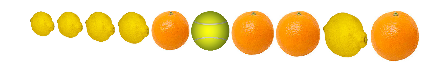

In [71]:
size_of_tennis_ball = 1
y = np.array(['lemon', 'lemon', 'lemon', 'lemon', 'orange', 'orange', 'orange', 'lemon', 'orange'])
x  = np.array([0.66, 0.7, 0.8, 0.85, 0.98, 1.1, 1.15, 1.2, 1.25])

draw_in_row(fruits, sizes)

# Priors

Lets assume that the prior probabilities for lemons and oranges are the proportions
of these fruits in our sample.

In [72]:
p_l = len(x[fruits == 'lemon'])/len(x)
p_o = len(x[fruits == 'orange'])/len(x)

print('P(Y_l) = {}'.format(p_l))
print('P(Y_o) = {}'.format(p_o))

P(Y_l) = 0.555555555556
P(Y_o) = 0.444444444444


## Density estimation

Lets make the assumption that the sizes of the different fruits are normally distributed with a mean and variance determined by the previous sample.

Thus we get the parameters $\mu$ and $\sigma^2$ by applying maximum likelihood

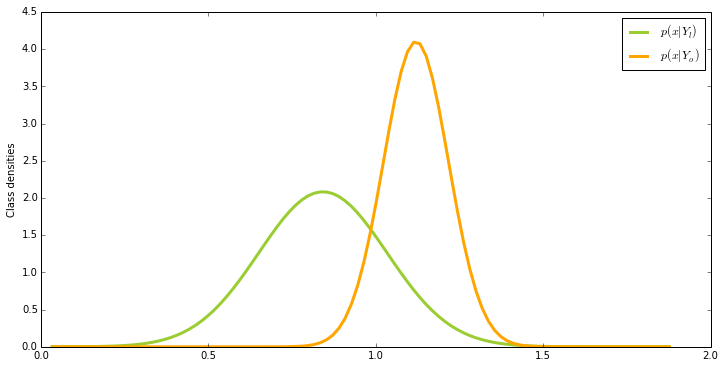

In [73]:
norm_l = NormalDistribution(x[y == 'lemon'])
norm_o = NormalDistribution(x[y == 'orange'])

x_lin = np.linspace(x.min()-3*x.std(), x.max()+3*x.std(), 100)

p_x_g_l = norm_l.pdf(x_lin)
p_x_g_o = norm_o.pdf(x_lin)

plt.plot(sizes_lin, p_x_g_l, color='yellowgreen', label='$p(x|Y_l)$', linewidth=3)
plt.plot(sizes_lin, p_x_g_o, color='orange', label='$p(x|Y_o)$', linewidth=3)
plt.ylabel('Class densities')
plt.legend()

# Posterior probabilities (Bayes' rule)

What are the posterior probabilities of each fruit given its relative size $s$

$$
    P(Y_l|x) = \frac{P(x|Y_l)*P(Y_l)}{P(x)}
$$

where

$$
    p(x) = \sum_k p(x|Y_k)p(Y_k)
$$

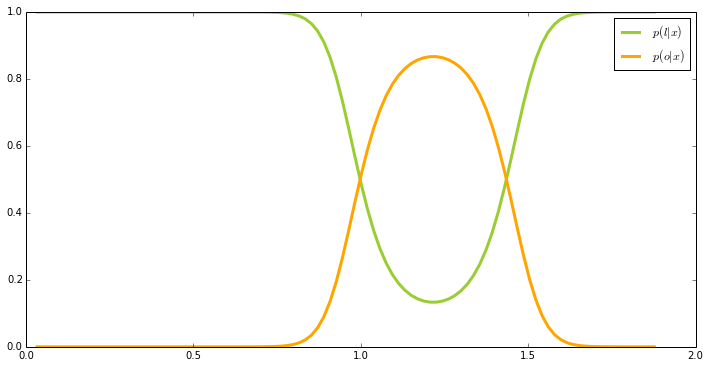

In [74]:
p_x = p_x_g_l*p_l + p_x_g_o*p_o

p_l_g_x = (p_x_g_l*p_l)/p_x
p_o_g_x = (p_x_g_o*p_o)/p_x

plt.plot(x_lin, p_l_g_x, color='yellowgreen', label='$p(l|x)$', linewidth=3)
plt.plot(x_lin, p_o_g_x, color='orange', label='$p(o|x)$', linewidth=3)
plt.legend()

### Discussion

To compute the posterior probabilities we divided the probabilities $p(x,Y_l)$ and $p(x,Y_o)$ to their sum. This is making the assumption that these two classes are all of the possible classes.

### Definition 1

For any instance x we define its familiarity factor $r(x)$ as follows:

$$
r(x) = \frac{p(f|x)}{p(b|x)}
$$

### Proposition 1

$$
p(b|x) = \frac{1}{1 + r(x)}, \\
p(f_c|x) = \frac{p(f_c|f,x)r(x)}{1+r(x)} \text{for} c = 1,\dots,k
$$

Now that we have this information we can try to estimate what is the probability of getting a lemon or an orange given a specific size.

Bayes theorem states that:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|\bar L)*P(\bar L)}
$$

However, because it is not possible to estimate $P(S)$ for all the possible objects, it is assumed that we can get an estimate in our given sample with lemons and apples. In our case, we are assuming that all the objects that are not lemons are apples. Then Bayes' theorem can be written as:

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A)}
$$

Where $P(A)$ is the probability of being an apple and $P(S|A)$ is the probability of being small given that it is an apple.

$$
    P(L|S) = \frac{P(S|L)*P(L)}{P(S)} = \frac{P(S|L)*P(L)}{P(S|L)*P(L) + P(S|A)*P(A) + P(S|\bar A, \bar L)*P(\bar A,\bar L)}
$$

## Deployment time

However, during deployment time there is nobody that can asure that the fruits that are being predicted are only lemons and oranges. It is possible that the factory got some other fruits in the collecting time.

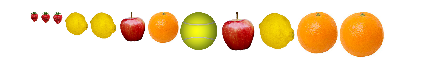

In [6]:
fruits = np.array(['strawberry', 'strawberry', 'strawberry', 'lemon', 'lemon', 'apple', 'orange',
                   'orange', 'apple', 'lemon', 'orange', 'orange'])
sizes  = np.array([.3, .33, .36, .7, .8, .85, .9, 1.1, 1.1, 1.1, 1.2, 1.3])

draw_in_row(fruits, sizes)

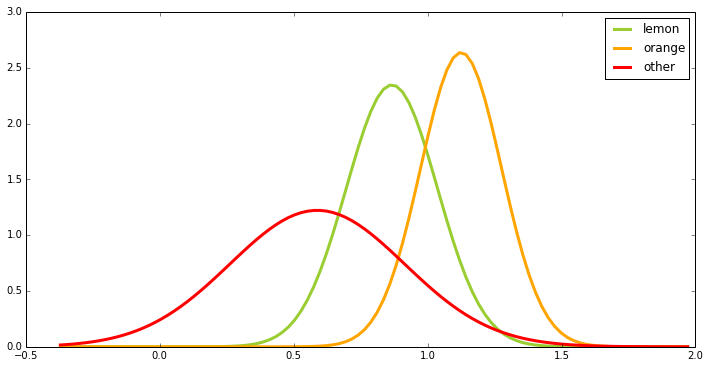

In [8]:
estimator_lemons = MyMultivariateNormal()
estimator_lemons.fit(sizes[fruits == 'lemon'])
estimator_oranges = MyGMM(n_components=1)
estimator_oranges.fit(np.array(sizes[fruits == 'orange']).reshape(-1,1))
estimator_background = MyMultivariateNormal()
estimator_background.fit(sizes[np.logical_and(fruits != 'lemon', fruits != 'orange')])

sizes_linspace = np.linspace(sizes.min()-2*sizes.std(), sizes.max()+2*sizes.std(), 100).reshape(-1,1)

P_R_g_L = estimator_lemons.score(sizes_linspace)
P_R_g_O = estimator_oranges.score(sizes_linspace)
P_R_g_nL_nO = estimator_background.score(sizes_linspace)

plt.plot(sizes_linspace, P_R_g_L, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_R_g_nL_nO, color='red', label='other', linewidth=3)
plt.legend()

# Posterior probabilities

What are the posterior probabilities of each fruit given its relative size $R$

$$
    P(L|R) = \frac{P(R|L)*P(L)}{P(R)} = \frac{P(R|L)*P(L)}{P(R|L)*P(L) + P(R|O)*P(O) + P(R|\bar O, \bar L)*P(\bar O,\bar L)}
$$

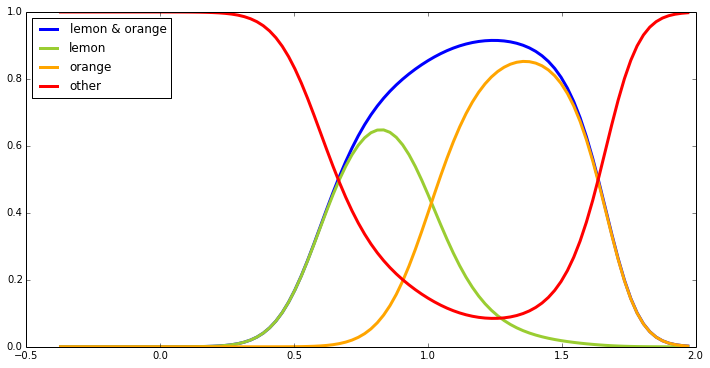

In [9]:
P_L = np.mean(fruits == 'lemon')
P_O = np.mean(fruits == 'orange')
P_nL_nO = P_L = np.mean(np.logical_and(fruits != 'lemon', fruits != 'orange'))

P_R = P_R_g_L*P_L + P_R_g_O*P_O + P_R_g_nL_nO*P_nL_nO

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R
P_nL_nO_g_R = P_R_g_nL_nO*P_nL_nO/P_R

plt.plot(sizes_linspace, P_L_g_R+P_O_g_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_L_g_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_O_g_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.legend(loc='upper left')

# Posterior probabilities

What are the posterior probabilities of each fruit given its relative size $R$

$$
    P(L|R) = \frac{P(R|L)*P(L)}{P(R)} = \frac{P(R|L)*P(L)}{P(R|L)*P(L) + P(R|O)*P(O) + P(R,B)}
$$

/usr/lib/pymodules/python2.7/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


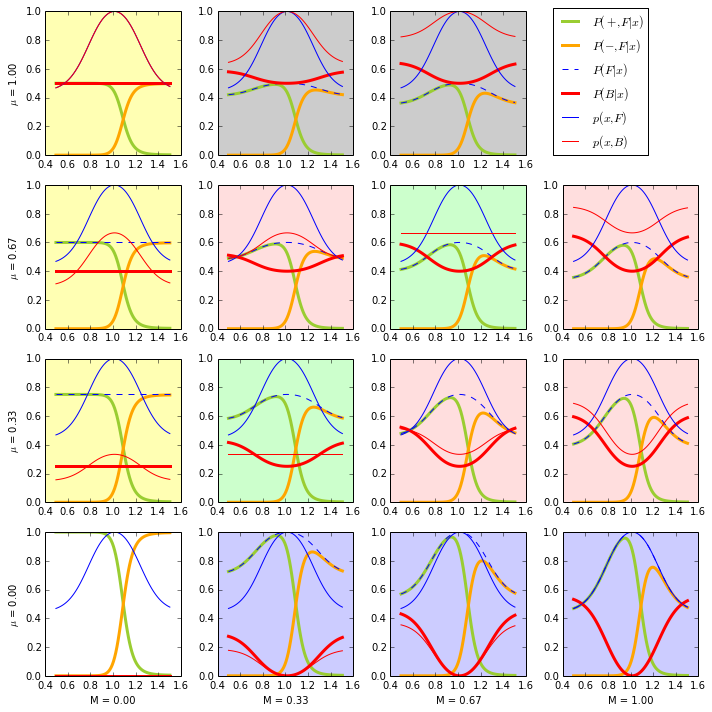

In [10]:
from matplotlib.gridspec import GridSpec
plt.rcParams['figure.autolayout'] = True

x = sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1)
sizes_linspace = np.linspace(x.min()-x.std(), x.max()+x.std(), 100).reshape(-1,1)

n_values = 4
values = np.linspace(0,1,n_values)

paint_background = True
fig = plt.figure(figsize=(10,10))
plt.subplot(n_values, n_values, 1)
for i, mu in enumerate(reversed(values)):
    for j, m in enumerate(values):
        estimator_foreground = BackgroundCheck(estimator=MyMultivariateNormal(), mu=mu, m=m)
        estimator_foreground.fit(x)
        q, p_x_and_b = estimator_foreground.compute_q_p_x_and_b(sizes_linspace)
        
        P_R = P_R_g_L*P_L + P_R_g_O*P_O

        P_L_g_R = P_R_g_L*P_L/P_R
        P_O_g_R = P_R_g_O*P_O/P_R
        
        P_B_g_R = p_x_and_b/(q+p_x_and_b)
        P_F_g_R = q/(q+p_x_and_b)
        
        P_L_F_g_R = P_L_g_R*P_F_g_R
        P_O_F_g_R = P_O_g_R*P_F_g_R
        
        if i == 0 and j == (n_values-1):
            ax = plt.legend(bbox_to_anchor=(1.2, 0), loc='lower left', borderaxespad=0.)
        else:
            ax = plt.subplot(n_values, n_values, i*n_values+j+1)
            ax.plot(sizes_linspace, P_L_F_g_R, color='yellowgreen', label='$P(+,F|x)$', linewidth=3)
            ax.plot(sizes_linspace, P_O_F_g_R, color='orange', label='$P(-,F|x)$', linewidth=3)
            ax.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='$P(F|x)$', linewidth=1)
            ax.plot(sizes_linspace, P_B_g_R, '-', color='red', label='$P(B|x)$', linewidth=3)

            ax.plot(sizes_linspace, q, '-', color='blue', label='$p(x,F)$')
            ax.plot(sizes_linspace, p_x_and_b, '-', color='red', label='$p(x,B)$')
            ax.set_ylim([0,1])
        
        if i == n_values-1:
            ax.set_xlabel('M = {:.2f}'.format(m))
        if j == 0:
            ax.set_ylabel('$\mu$ = {:.2f}'.format(mu))
        
        if paint_background:
            if i == n_values-1:
                ax.set_axis_bgcolor((.8,.8,1))

            if j == 0:
                ax.set_axis_bgcolor((1,1,.7))

            if i == (n_values-1) and j == 0:
                ax.set_axis_bgcolor((1,1,1))
            elif (i != (n_values-1) and j != 0) and not (i == 0 and j == (n_values-1)):
                if (n_values-i-1) == j:
                    ax.set_axis_bgcolor((0.8,1,0.8))
                elif i == 0:
                    ax.set_axis_bgcolor((.8,.8,.8))
                else:
                    ax.set_axis_bgcolor((1,.87,.87))

            
fig.savefig('check_your_background_fig_1.pdf')

In [11]:
est_1 = BackgroundCheck(mu=mu, m=m)
est_2 = BackgroundCheck(estimator=MultivariateNormal(), mu=mu, m=m)
est_3 = BackgroundCheck(estimator=MyMultivariateNormal(), mu=mu, m=m)
est_4 = BackgroundCheck(estimator=MyGMM(), mu=mu, m=m)

est_1.fit(x)
est_2.fit(x)
est_3.fit(x)
est_4.fit(x)

print("\nMaximum score")
print est_1.score(x).max()
print est_2.score(x).max()
print est_3.score(x).max()
print est_4.score(x).max()

print("\nMaximum estimator score")
print est_1._estimator.score(x).max()
print est_2._estimator.score(x).max()
print est_3._estimator.score(x).max()
print est_4._estimator.score(x).max()

print("\nMaximum dens")
print est_1._max_dens
print est_2._max_dens
print est_3._max_dens
print est_4._max_dens


Maximum score
0.576440366445
1.79735106288
1.79735106288
1.77969209045

Maximum estimator score
0.576440366445
1.79735106288
1.79735106288
1.77969209045

Maximum dens
0.746994883246
0.769301704114
0.797684540573
0.764392706776


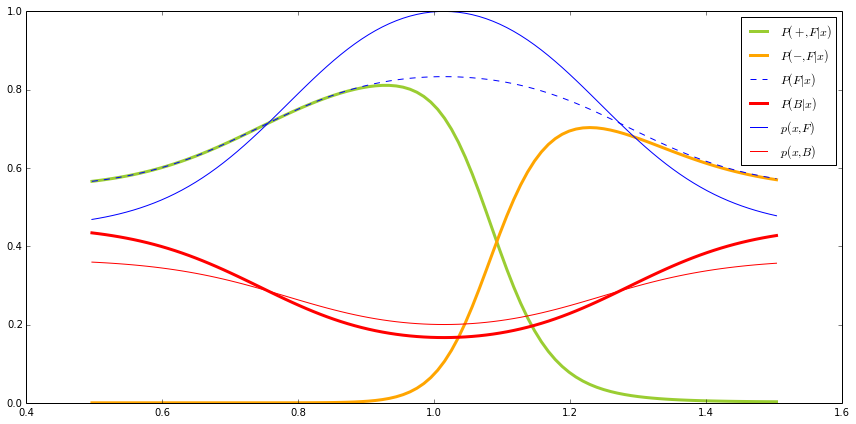

In [12]:
estimator_foreground = BackgroundCheck(estimator=MyMultivariateNormal(), mu=0.2, m=0.5)
estimator_foreground.fit(x)
q, p_x_and_b = estimator_foreground.compute_q_p_x_and_b(sizes_linspace)

P_R = P_R_g_L*P_L + P_R_g_O*P_O

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R

P_B_g_R = p_x_and_b/(q+p_x_and_b)
P_F_g_R = q/(q+p_x_and_b)

P_L_F_g_R = P_L_g_R*P_F_g_R
P_O_F_g_R = P_O_g_R*P_F_g_R



plt.figure()
ax = plt.subplot(111)
ax.plot(sizes_linspace, P_L_F_g_R, color='yellowgreen', label='$P(+,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_O_F_g_R, color='orange', label='$P(-,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='$P(F|x)$', linewidth=1)
ax.plot(sizes_linspace, P_B_g_R, '-', color='red', label='$P(B|x)$', linewidth=3)

ax.plot(sizes_linspace, q, '-', color='blue', label='$p(x,F)$')
ax.plot(sizes_linspace, p_x_and_b, '-', color='red', label='$p(x,B)$')
ax.set_ylim([0,1])
ax.legend()

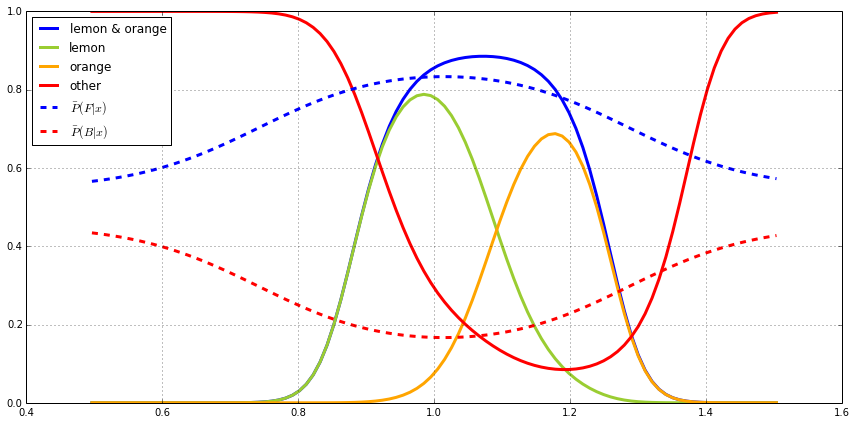

In [13]:
estimator_foreground = BackgroundCheck(mu=0.9, m=0.5)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

P_R = P_R_g_L*P_L + P_R_g_O*P_O + P_B_g_R

plt.plot(sizes_linspace, (P_R_g_L*P_L + P_R_g_O*P_O)/P_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_R_g_L*P_L/P_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O*P_O/P_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.plot(sizes_linspace, P_F_g_R, '--', color='blue', label=r'$\barP(F|x)$', linewidth=3)
plt.plot(sizes_linspace, P_B_g_R, '--', color='red', label=r'$\barP(B|x)$', linewidth=3)
plt.legend(loc='upper left')
plt.grid(True)

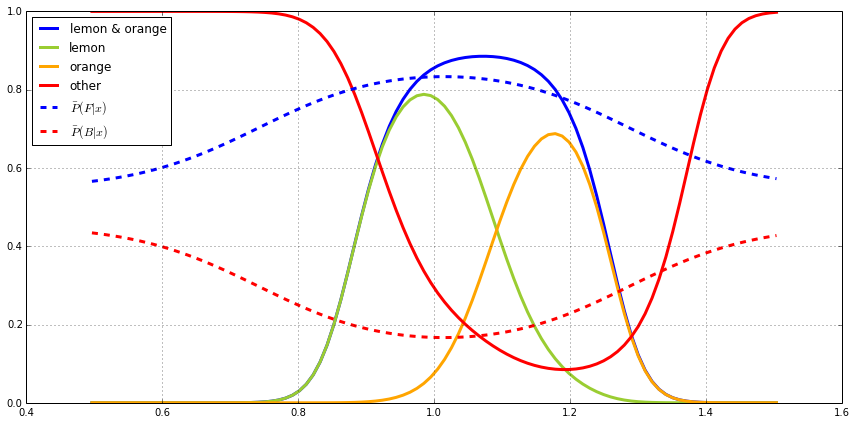

In [14]:
estimator_foreground = BackgroundCheck(mu=0.2, m=0.8)
estimator_foreground.fit(sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1))

P_R = P_R_g_L*P_L + P_R_g_O*P_O + P_B_g_R

plt.plot(sizes_linspace, (P_R_g_L*P_L + P_R_g_O*P_O)/P_R, color='blue', label='lemon & orange', linewidth=3)
plt.plot(sizes_linspace, P_R_g_L*P_L/P_R, color='yellowgreen', label='lemon', linewidth=3)
plt.plot(sizes_linspace, P_R_g_O*P_O/P_R, color='orange', label='orange', linewidth=3)
plt.plot(sizes_linspace, P_nL_nO_g_R, color='red', label='other', linewidth=3)
plt.plot(sizes_linspace, P_F_g_R, '--', color='blue', label=r'$\barP(F|x)$', linewidth=3)
plt.plot(sizes_linspace, P_B_g_R, '--', color='red', label=r'$\barP(B|x)$', linewidth=3)
plt.legend(loc='upper left')
plt.grid(True)


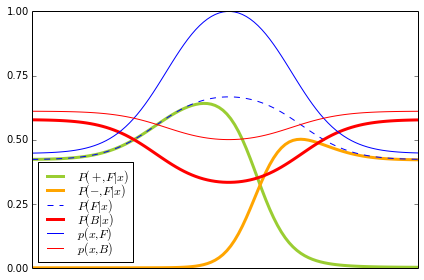

In [15]:
mu=0.5
m=0.7

plt.rcParams['figure.autolayout'] = True

x = sizes[np.logical_or(fruits == 'lemon', fruits == 'orange')].reshape(-1,1)
sizes_linspace = np.linspace(x.min()-2*x.std(), x.max()+2*x.std(), 100).reshape(-1,1)

fig = plt.figure(figsize=(6,4))

estimator_foreground = BackgroundCheck(estimator=MyMultivariateNormal(), mu=mu, m=m)
estimator_foreground.fit(x)
q, p_x_and_b = estimator_foreground.compute_q_p_x_and_b(sizes_linspace)

P_R = P_R_g_L*P_L + P_R_g_O*P_O

P_L_g_R = P_R_g_L*P_L/P_R
P_O_g_R = P_R_g_O*P_O/P_R

P_B_g_R = p_x_and_b/(q+p_x_and_b)
P_F_g_R = q/(q+p_x_and_b)

P_L_F_g_R = P_L_g_R*P_F_g_R
P_O_F_g_R = P_O_g_R*P_F_g_R

ax = plt.subplot(111)
ax.plot(sizes_linspace, P_L_F_g_R, color='yellowgreen', label='$P(+,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_O_F_g_R, color='orange', label='$P(-,F|x)$', linewidth=3)
ax.plot(sizes_linspace, P_F_g_R, '--', color='blue', label='$P(F|x)$', linewidth=1)
ax.plot(sizes_linspace, P_B_g_R, '-', color='red', label='$P(B|x)$', linewidth=3)

ax.plot(sizes_linspace, q, '-', color='blue', label='$p(x,F)$')
ax.plot(sizes_linspace, p_x_and_b, '-', color='red', label='$p(x,B)$')
ax.set_ylim([0,1])
ax.set_xlim([sizes_linspace.min(), sizes_linspace.max()])
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
ax.legend(loc='lower left', labelspacing=-0.3)